In [2]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1";


%load_ext autoreload
%autoreload 2
from CW import CW
from FGSM import FGSM
from OPT_attack import OPT_attack
from OPT_attack_polar import OPT_attack_polar
from OPT_attack_polar_GD import OPT_attack_polar_GD
from OPT_attack_lsq import OPT_attack_lsq
from OPT_attack_polar_lsq import OPT_attack_polar_lsq
from OPT_attack_GD import OPT_attack_GD
from OPT_genattack import OPT_genattack
from OPT_attack_sign_SGD_batch import OPT_attack_sign_SGD
from ZOO import ZOO
from OPT_attack_lf import OPT_attack_lf
from nes_attack import NES
from models import PytorchModel
import torch
from allmodels import MNIST, load_model, load_mnist_data, load_cifar10_data, CIFAR10
import os
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


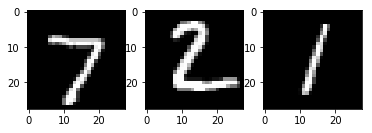

In [3]:
net = MNIST()
net.cuda()
net = torch.nn.DataParallel(net, device_ids=[0])
# print(net)
load_model(net,'mnist_gpu.pt')
net.eval()
model = net.module if torch.cuda.is_available() else net
# model = model.cpu()
train_loader, test_loader, train_dataset, test_dataset = load_mnist_data()

X0, Y0 = None, None
X1, Y1 = None, None
X2, Y2 = None, None
for i, (xi,yi) in enumerate(test_loader):
    if i==0:
        X0, Y0 = xi, yi
    if i==1:
        X1, Y1 = xi, yi
    if i==2:
        X2, Y2 = xi, yi
        
amodel = PytorchModel(model, bounds=[0,1], num_classes=10)

def plot_adv(X, adv):
    plt.subplot(1,2,1)
    plt.imshow(X[0][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(adv.cpu()[0][0], cmap='gray')
    plt.show()

# Plot the sample images
plt.subplot(1,3,1)
plt.imshow(X0[0][0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(X1[0][0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(X2[0][0], cmap='gray')
plt.show()

### Baseline distortions for 3 examples (Original Randomized Gradient Free optimization)

In [8]:
# These distortions were calculated by taking average of 10 trials for each example
# using the randomized gradient free method.
d0 = (1.5292 + 1.5095 + 1.4743 + 1.3108 + 1.2816 + 1.4416 + 1.5323 + 1.3404 + 1.3365 + 1.3819)/10
d1 = (1.2531 + 1.3640 + 1.2929 + 1.2826 + 1.2985 + 1.3726 + 1.3016 + 1.2917 + 1.2976 + 1.2911)/10
d2 = (0.7499 + 0.7520 + 0.7615 + 0.7599 + 0.7609 + 0.7635 + 0.7450 + 0.7497 + 0.8018 + 0.7475)/10
print("d0 ", d0)
print("d1 ", d1)
print("d3 ", d2)

d0  1.41381
d1  1.30457
d3  0.7591699999999999


### Original - Randomized Gradient Free optimization

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Searching for the initial direction on 100 random directions: 
--------> Found distortion 10.5559
--------> Found distortion 8.2396
--------> Found distortion 7.4332
--------> Found distortion 7.3008
--------> Found distortion 7.1342
==========> Found best distortion 7.1342 in 0.7941 seconds using 298 queries
Iteration  10 distortion 4.7967 num_queries 2135
Iteration  20 distortion 3.6755 num_queries 4211
Iteration  30 distortion 3.0488 num_queries 6263
Iteration  40 distortion 2.6259 num_queries 8247
Iteration  50 distortion 2.3526 num_queries 10132
Iteration  60 distortion 2.1996 num_queries 12036
Iteration  70 distortion 2.0934 num_queries 13944
Iteration  80 distortion 1.9957 num_queries 15871
Iteration  90 distortion 1.8890 num_queries 17775
Iteration 100 distortion 1.8078 num_queries 19691
Iteration 110 distortion 1.7502 num_queries 21572
Iteration 120 distortion 1.6811 num_queries 23461
Iteration 130 distortion 1.6422 num_queries 25314
Iteration 140 distortion 1.6102 num_queries

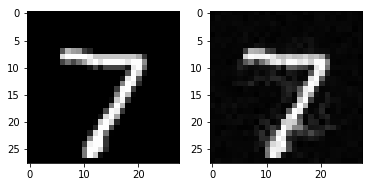

In [11]:
attack = OPT_attack(amodel)
adv, dist = attack(X0.cuda(), Y0.cuda())
plot_adv(X0, adv)

### SIGN SGD

In [6]:
attack = OPT_attack_sign_SGD(amodel)
adv_sign, dist_sign = attack(X2.cuda(), Y2.cuda(), seed=10)
plot_adv(X2, adv_sign)

Running gradient descent with start learning rate  1.0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.9012
--------> Found distortion 3.5285
--------> Found distortion 3.4555
==========> Found best distortion 3.4555 in 1.5147 seconds using 257 queries
(1, 1, 28, 28)


RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Running gradient descent with start learning rate  1.0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 9.7503
--------> Found distortion 8.0516
--------> Found distortion 7.4211
--------> Found distortion 6.9725
--------> Found distortion 6.9196
--------> Found distortion 6.7569
--------> Found distortion 6.4861
--------> Found distortion 5.8502
==========> Found best distortion 5.8502 in 0.5137 seconds using 354 queries
Iteration   1 distortion 4.2335 num_queries 633
Iteration   6 distortion 2.2681 num_queries 2059
Iteration  11 distortion 1.7406 num_queries 3341
Iteration  16 distortion 1.5413 num_queries 4606
Iteration  21 distortion 1.4444 num_queries 5843
Iteration  26 distortion 1.4046 num_queries 7045
Iteration  31 distortion 1.3660 num_queries 8251
Iteration  36 distortion 1.3485 num_queries 9419
Iteration  41 distortion 1.3348 num_queries 10630
Iteration  46 distortion 1.3276 num_queries 11786
Iteration  51 distortion 1.3224 num_querie

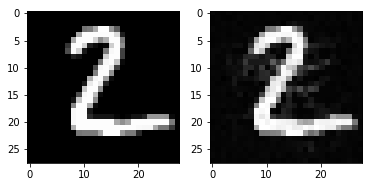

In [7]:
attack = OPT_attack_sign_SGD(amodel)
adv_sign, dist_sign = attack(X1.cuda(), Y1.cuda(), svm=True, seed=100)
plot_adv(X1, adv_sign)

Running gradient descent with start learning rate  1.0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.9012
--------> Found distortion 3.5285
--------> Found distortion 3.4555
==========> Found best distortion 3.4555 in 1.9772 seconds using 257 queries
Iteration   1 distortion 3.4555 num_queries 713
Success: stopping threshold reached

Adversarial Example Found Successfully: distortion 3.4555 target 4 queries 1217 
Time: 7.6294 seconds


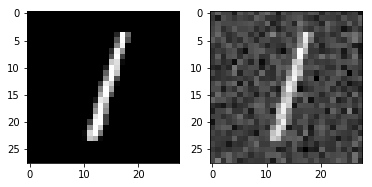

In [14]:
attack = OPT_attack_sign_SGD(amodel)
adv_sign, dist_sign = attack(X2.cuda(), Y2.cuda(), seed=10, momentum=0.9)
plot_adv(X2, adv_sign)

### Normal Gradient Descent

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Running gradient descent with learning rate  0.05
Searching for the initial direction on 100 random directions: 
--------> Found distortion 8.6650
--------> Found distortion 8.3280
--------> Found distortion 7.3320
--------> Found distortion 7.2684
==========> Found best distortion 7.2684 in 0.3921 seconds using 278 queries
Gradient norm:  33.858082160130465
Iteration:  0  Distortion:  2.8751678531016553  Queries:  13721
Gradient norm:  5.565591148655709
Iteration:  1  Distortion:  2.3290906329583585  Queries:  25521
Gradient norm:  3.0748165460323116
Iteration:  2  Distortion:  2.1921277333398574  Queries:  37305
Gradient norm:  2.6954033879180144
Iteration:  3  Distortion:  2.1083153633746115  Queries:  49085
Gradient norm:  2.4523847899539275
Iteration:  4  Distortion:  2.050357175088064  Queries:  60863
Gradient norm:  2.3039683311972596
Iteration:  5  Distortion:  2.0058473203501457  Queries:  72641
Gradient norm:  2.1923677089515796
Iteration:  6  Distortion:  1.9703272645005245 

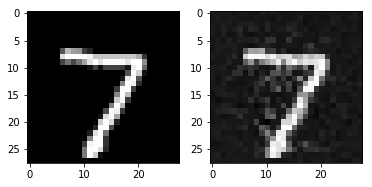

In [25]:
attack = OPT_attack_GD(amodel)
adv_gd, dist_gd = attack(X0.cuda(), Y0.cuda(), distortion=2.0)
plot_adv(X0, adv_gd)

### Gradient Descent With Least Squares Estimation

In [34]:
attack = OPT_attack_lsq(amodel)
adv_lsq, dist_lsq = attack(X0.cuda(), Y0.cuda(), distortion=d0)
plot_adv(X0, adv_lsq)

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Running gradient descent with learning rate  0.05
Searching for the initial direction on 100 random directions: 
--------> Found distortion 9.6806
--------> Found distortion 8.6644
--------> Found distortion 8.3515
--------> Found distortion 7.8923
--------> Found distortion 7.8217
--------> Found distortion 6.8431
==========> Found best distortion 6.8431 in 0.4492 seconds using 316 queries


KeyboardInterrupt: 

###  Polar coordinates: Original Randomized Gradient Free optimization

In [3]:
attack = OPT_attack_polar(amodel)
adv = attack(X0.cuda(), Y0.cuda())

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Searching for the initial direction on 100 random directions: 
--------> Found distortion 9.3599
--------> Found distortion 7.9540
--------> Found distortion 7.9164
--------> Found distortion 7.4414
==========> Found best distortion 7.4414 in 0.4024 seconds using 278 queries
Iteration  50: g(theta + beta*u) = 2.78794929 g(theta) = 2.7880 distortion 2.78799013 num_queries 11441
Iteration 100: g(theta + beta*u) = 2.04315996 g(theta) = 2.0432 distortion 2.04321608 num_queries 21058
Iteration 150: g(theta + beta*u) = 1.75980538 g(theta) = 1.7598 distortion 1.75982256 num_queries 30518
Iteration 200: g(theta + beta*u) = 1.60864118 g(theta) = 1.6087 distortion 1.60865100 num_queries 39711
Iteration 250: g(theta + beta*u) = 1.51528060 g(theta) = 1.5153 distortion 1.51526765 num_queries 48462
Iteration 300: g(theta + beta*u) = 1.46450895 g(theta) = 1.4645 distortion 1.46450716 num_queries 57174
Iteration 350: g(theta + beta*u) = 1.43600352 g(theta) = 1.4360 distortion 1.43600177 num_queries 65

### Polar with gradient bias

In [5]:
attack = OPT_attack_polar(amodel, gradient_bias=True)
adv = attack(X0.cuda(), Y0.cuda())

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Searching for the initial direction on 100 random directions: 
--------> Found distortion 10.7166
--------> Found distortion 9.0882
--------> Found distortion 9.0443
--------> Found distortion 8.9503
--------> Found distortion 7.8088
--------> Found distortion 7.6667
==========> Found best distortion 7.6667 in 0.4274 seconds using 317 queries
Iteration   1: g(theta + beta*u) = 7.69211076 g(theta) = 7.6667 distortion 7.66672736 num_queries 170 grad_queries 13311 total_queries 13481
Iteration   2: g(theta + beta*u) = 3.72509454 g(theta) = 3.7233 distortion 3.72327086 num_queries 714 grad_queries 25839 total_queries 26553
Iteration   3: g(theta + beta*u) = 2.84039257 g(theta) = 2.8400 distortion 2.84004068 num_queries 999 grad_queries 37584 total_queries 38583
Iteration   4: g(theta + beta*u) = 2.58325724 g(theta) = 2.5829 distortion 2.58288835 num_queries 1197 grad_queries 49329 total_queries 50526
Iteration   5: g(theta + beta*u) = 2.49771851 g(theta) = 2.4976 distortion 2.49756607 num_

KeyboardInterrupt: 

### Gradient Descent Least Squares - POLAR

In [ ]:
attack = OPT_attack_polar_lsq(amodel)
adv = attack(X0.cuda(), Y0.cuda())

/home/simranjit/blackbox/attackbox-master/models.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image = Variable(image, volatile=True) # ?? not supported by latest pytorch


Running gradient descent with learning rate  0.01
Searching for the initial direction on 100 random directions: 
--------> Found distortion 9.1506
--------> Found distortion 7.7997
--------> Found distortion 7.4634
==========> Found best distortion 7.4634 in 0.3991 seconds using 259 queries
Numerical - Approx gradient cosine distance: 0.5334463110422887, Distance moved: 0.14991986971585872
Iteration:  0  Distortion:  5.99790873127015  Queries:  5384
Numerical - Approx gradient cosine distance: 0.21909010602390366, Distance moved: 0.12717967491055976
Iteration:  1  Distortion:  5.081077735416738  Queries:  10503
Numerical - Approx gradient cosine distance: 0.19977321574276885, Distance moved: 0.08578149317792327
Iteration:  2  Distortion:  4.595906534922734  Queries:  15614
Numerical - Approx gradient cosine distance: 0.14901922655324196, Distance moved: 0.06578151899909716
Iteration:  3  Distortion:  4.269898387573788  Queries:  20723
Numerical - Approx gradient cosine distance: 0.1120

### Polar gradient descent

In [ ]:
attack = OPT_attack_polar_GD(amodel)
adv = attack(X0.cuda(), Y0.cuda())

### Conversion from cartesian to polar coordinates
We may define a coordinate system in an n-dimensional Euclidean space which is analogous to the spherical coordinate system defined for 3-dimensional Euclidean space, in which the coordinates consist of a radial coordinate r, and n − 1 angular coordinates φ1, φ2, ... φn−1, where the angles φ1, φ2, ... φn−2 range over [0,π] radians (or over [0,180] degrees) and φn−1 ranges over [0,2π) radians (or over [0,360) degrees). If xi are the Cartesian coordinates, then we may compute x1, ... xn from r, φ1, ... φn−1 with:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/0c4349e9ce260f719ebf573067bc7b84305ae31c">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/3D_Spherical.svg/480px-3D_Spherical.svg.png">

In [6]:
def polar_to_ct(r, arr):
    a = np.concatenate((np.array([2*np.pi]), arr))
    si = np.sin(a)
    si[0] = 1
    si = np.cumprod(si)
    co = np.cos(a)
    co = np.roll(co, -1)
    return si*co*r

In [16]:
import numpy as np
print(polar_to_ct(1, [-0.2, np.pi/4, np.pi/4, np.pi/2]))

[  9.80066578e-01  -1.40480431e-01  -9.93346654e-02  -6.08249400e-18
  -9.93346654e-02]


In [20]:
def ct_to_polar(arr, eps=1e-5):
    arr = np.array(arr)
    arr2 = arr**2 + eps
    r = np.sqrt(np.sum(arr2))
    arr2 = np.flip(np.cumsum(np.flip(arr2, axis=0)), axis=0)
    arr2 = np.sqrt(arr2)
    phi = np.arccos((arr/arr2)[:-1])
    if arr[-1] < 0:
        phi[-1] = 2*np.pi - phi[-1]
    # phi = np.concatenate((np.array([r]), phi))
    return r, phi

In [21]:
print(ct_to_polar([9.80066578e-01,-1.40480431e-01,-9.93346654e-02,-6.08249400e-18,-9.93346654e-02]))

(1.0000249998409219, array([ 0.20012329,  2.35568828,  2.35543556,  4.71238898]))


In [13]:
print([1.5*np.pi, np.pi/4 - 0.7859, np.pi/4 - 0.78615, np.pi/2 - 1.5707])

[4.71238898038469, -0.000501836602551764, -0.0007518366025517365, 9.632679489657292e-05]


In [18]:
print([1.5*np.pi, np.pi/4 - 2.3556, np.pi/4 - 2.3554, np.pi/2 - 4.712])

[4.71238898038469, -1.5702018366025516, -1.5700018366025517, -3.141203673205103]


In [10]:
a = np.array([[1,2],[3,4]])
print(a)
print(a.repeat(2, axis=0))
print(a.repeat(2, axis=1))
print(a.repeat(2, axis=0).repeat(2, axis=1).shape)

[[1 2]
 [3 4]]
[[1 2]
 [1 2]
 [3 4]
 [3 4]]
[[1 1 2 2]
 [3 3 4 4]]
(4, 4)


In [33]:
import scipy.spatial
scipy.spatial.distance.cosine(np.array([1,2]), np.array([-2,1]))

1.0